<a href="https://colab.research.google.com/github/chinsengi/sharpdim/blob/main/simpleFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [2]:
def get_gradW(model, dataloader, ndata, k=1):
    # assert dataloader.batch_size == 1
    gradtheta = 0
    gradW = 0
    B = 0
    for _ in range(ndata):
        X, y = next(dataloader)
        X, y = X.cuda(), y.cuda()
        logits = model(X).reshape(1, -1)
        output_dim = logits.shape[1]
        normX = torch.linalg.vector_norm(X.flatten(), 2).item()
        old_gradW = gradW
        for j in range(output_dim):
            logit = logits[0][j]
            model.zero_grad()
            logit.backward(retain_graph=True)

            grad = [p.grad.detach().cpu().numpy() for p in model.parameters()]
            grad = [np.reshape(g, (-1)) for g in grad]
            cur_gradtheta = np.concatenate(grad)
            W = get_first_layer_weight(model)
            if W is not None:
                cur_gradW = W.grad.detach().cpu().numpy()
            else:
                cur_gradW = 0
            gradtheta += np.sum(cur_gradtheta**2)
            gradW += np.sum(cur_gradW**2)
        B += np.sqrt(gradW - old_gradW) / normX
    return np.sqrt(gradW / ndata), np.sqrt(gradtheta / ndata), B / ndata


def get_first_layer_weight(model):
    for param in model.parameters():
        if len(param.shape) == 2:  # Check if the parameter is a weight matrix (2D)
           return param
        break
    return None


def get_dim(model, dataloader, ndata):
    # assert dataloader.batch_size == 1
    dim = 0
    log_vol = 0
    G = 0
    A = 0
    B = 0
    for _ in range(ndata):
        X, y = next(dataloader)
        X, y = X.cuda(), y.cuda()
        X.requires_grad = True
        logits = model(X).reshape(1, -1)
        grad_x = np.zeros((logits.shape[1], torch.numel(X)))
        old_G = G
        for j in range(logits.shape[1]):
            logit = logits[0][j]
            model.zero_grad()
            grad = torch.autograd.grad(logit, X, retain_graph=True)[0]
            grad = grad.cpu().detach().numpy()
            grad = np.reshape(grad, (-1))
            grad_x[j, :] = grad
            G += np.sum(grad**2)
        sing_val = np.linalg.svd(grad_x, compute_uv=False)
        eig_val = sing_val**2
        A += np.max(sing_val)
        cur_dim = np.sum(eig_val) ** 2 / np.sum(eig_val**2)
        dim += cur_dim
        log_vol += cal_logvol(eig_val, cur_dim)
    return dim / ndata, log_vol / ndata, G / ndata, eig_val, A / ndata


def cal_logvol(eig_val, dim):
    # return np.sum(np.log(eig_val[:math.floor(dim.item())])) / 2
    return np.sum(np.log(eig_val[:3])) / 2


def min_norm(dataloader, ndata):
    min_norm = 1e10
    for i in range(ndata):
        X, y = next(dataloader)
        min_norm = min(min_norm, torch.linalg.matrix_norm(X, "fro").item())
    return min_norm


def quad_mean(dataloader, ndata):
    quad = 0
    for i in range(ndata):
        X, y = next(dataloader)
        quad += 1 / torch.linalg.vector_norm(X.flatten(), 2).item() ** 2
    return np.sqrt(quad / ndata)

In [3]:
class FNN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(FNN, self).__init__()
        self.net = nn.Sequential(nn.Linear(in_dim,hid_dim),
                        nn.ReLU(),
                        nn.Linear(hid_dim,hid_dim),
                        nn.ReLU(),
                        nn.Linear(hid_dim,hid_dim),
                        nn.ReLU(),
                        nn.Linear(hid_dim,out_dim))

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        o = self.net(x)
        return o

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST dataset
# mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
FashionMNIST_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
# Create a DataLoader
batch_size = 20
# mnist_dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)
fashionmnist_dataloader = DataLoader(FashionMNIST_dataset, batch_size=batch_size, shuffle=True)



In [5]:
device = 'cuda'
model = FNN(28*28, 500, 10).to(device)

# Step 4: Loss Function
criterion = nn.MSELoss()

# Step 5: Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.2)

# Step 6: Training Loop
num_epochs = 500
G_list = []
sharpness_list = []
loss_list = []
for epoch in tqdm(range(num_epochs)):
  for X_train, y_train in fashionmnist_dataloader:
    X_train, y_train = X_train.cuda(), y_train.cuda()
    y_train = torch.nn.functional.one_hot(y_train, 10).float().cuda()
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  # if (epoch + 1) % 1 == 0:
  #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
  if (epoch + 1) % 10 == 0:
      loss_list.append(loss.item())
      dim_dataloader = DataLoader(FashionMNIST_dataset, batch_size=1, shuffle=True)
      dim, log_vol, G, eig_val, A = get_dim(model, iter(dim_dataloader), 20)
      gradW, sharpness, B = get_gradW(model, iter(dim_dataloader), 20)

      G_list.append(G)
      sharpness_list.append(sharpness)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:51:29<00:00, 13.38s/it]


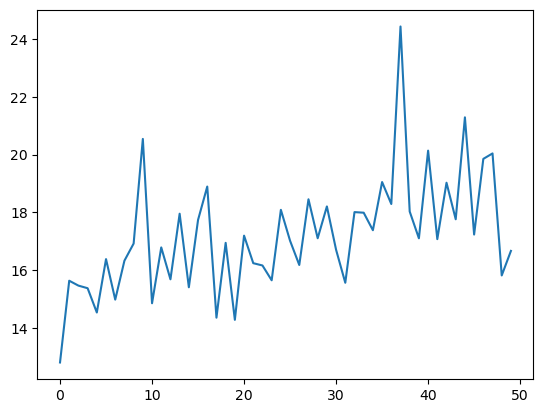

In [6]:
plt.plot(sharpness_list)

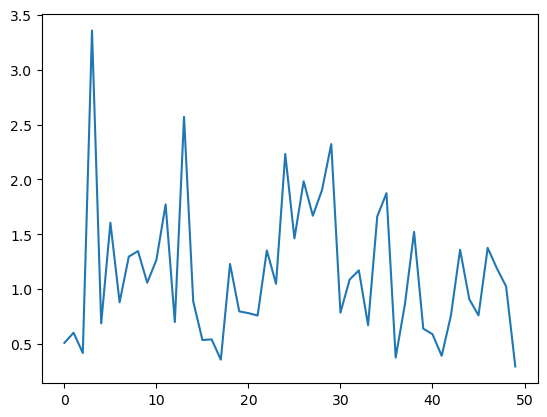

In [7]:
plt.plot(G_list)

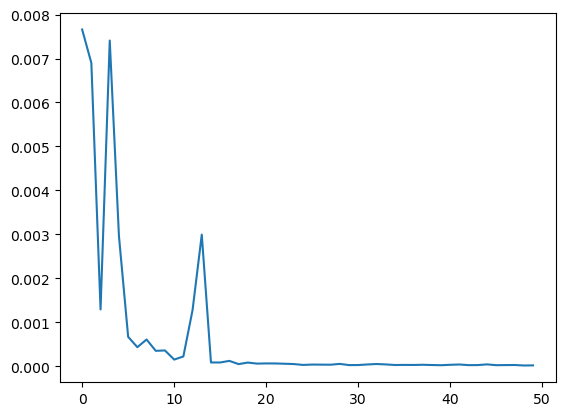

In [8]:
plt.plot(loss_list)

In [ ]:
# calculate dimension, log volume, G and eigenvalues.
dim_dataloader = DataLoader(mnist_dataset, batch_size=1, shuffle=True)
dim, log_vol, G, eig_val, A = get_dim(model, iter(dim_dataloader), 20)


In [14]:
# calculate sharpness
gradW, sharpness, B = get_gradW(model, iter(dim_dataloader), 20)
print(sharpness)

21.551990323966884


In [ ]:
# calculate min input 2-norm and the norm of first layer.
W_norm = None
for param in model.parameters():
    if (
        len(param.shape) == 2
    ):  # Check if the parameter is a weight matrix (2D)
        W_norm = torch.linalg.matrix_norm(param, 2)
    break
quad = quad_mean(iter(dim_dataloader), 20)

In [ ]:
import os
def create_dir(path="./model"):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

def save_model(model, optimizer, path, filename):
    create_dir(path)
    states = [model.state_dict(), optimizer.state_dict()]
    torch.save(states, os.path.join(path, filename))

save_model(model, optimizer, "./weights", "test")